In [1]:
%gui qt
%matplotlib notebook

import pandas as pd
import numpy as np
import scipy
from scipy import stats,signal
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import KF2D
import pickle
import os,glob, csv
import cpd
from scipy.signal import hilbert

import numpy as np
from numpy import linalg as LA

from filters import butter_lowpass_lfilter, butter_highpass_lfilter
from pykalman import KalmanFilter
import peakdet
import pdb
from __future__ import division

In [2]:
def findHW(data,fs=25,thresh = 0.02, filt = 'HPF'):
    N = len(data) #number samples

    HPF_mid = butter_highpass_lfilter(data,.15,25)#.1
    BPF_mid = butter_lowpass_lfilter(HPF_mid,2.5,25)#.9

    #make window
    x = len(BPF_mid[100:])
    Nx = int(pow(2, np.floor(np.log(x)-1/np.log(2)))); #find window size (nearest base 2 value less than length of data), based on length of values
    win = scipy.signal.get_window('hann',Nx=Nx)
    print('Window size is {}'.format(Nx))

    #start 100 timesteps in, to get rid of onset ringing
    if filt=='HPF':
        signal = HPF_mid
    elif filt == 'BPF':
        signal = BPF_mid
    elif filt == 'None':
        signal == data
        
    f_x, t_x, S_x = scipy.signal.spectrogram(signal[fs*2:],fs=fs,window=win,nfft=Nx,nperseg=Nx)#red_mat[:,2],fs) #x velocity

    thresh_f = next(x[0] for x in enumerate(f_x) if x[1] > 0) #frequency threshold
    print("Frequency threshold is {}".format(thresh_f))
    s_dt = np.diff(t_x)[0]   #timestep of spectrogram
    dt = np.diff(t_x)[0]*25

    print(np.mean(S_x),np.std(S_x))

    #plot spectrogram
    plt.figure()
    plt.pcolormesh(t_x+T[0], f_x, S_x, cmap='jet')
    plt.colorbar()
    plt.ylabel('Midpoint Frequency (Hz)') #previously "xdot freq" is this velocity? pretty sure this is position
    plt.xlabel('Time (s)')
    plt.ylim((0,fs/2))
    plt.show()

    #frame number where headwagging occurs
    head_wag = []
    head_wag_idx = []
    hw_freq = []

    #find where frequency is larger than some threshold. Currently 0.02, not sure why.
    for i in range(S_x.shape[1]-1):
        if max(S_x[thresh_f:,i])>=thresh:
#             print(i)
            head_wag.append(np.round(t_x.T[i] + T[0],2))# + s_dt*1.5)))
            hw_freq.append(f_x[list(np.where(S_x==max(S_x[thresh_f:,i]))[0])]) #finds dominant power frequency
            #hw_freq.append(f_x[thresh_f:,i])

    #get indices where head wagging is detected
    for i in range(len(head_wag)):
        if i==head_wag[i-1]+s_dt:
            continue
        else:
            try:
                head_wag_idx.append(list(np.where(np.round(T,2)==head_wag[i]+2)[0])[0])  #+T[0] deals with time offset between real time and spectrogram time
            except:
                print('Could not find time equal to {}. Check framerate and retry.'.format(np.round(head_wag[i],2)))
                
    hw_events = []
#     hw_cpd = []
    hw_vd = []
    hw_loc = []
    hw_bool = np.zeros(np.size(HPF_mid), dtype=bool)

    #TODO: make separate cell for hw_cpd, hw_vd
    for row in head_wag_idx:
#         pdb.set_trace()

        if row+Nx < len(signal):
            hw_loc.extend(range(row,row+Nx))
            hw_events.extend(data[row:row+Nx])#[row:row+Nx,0])
            hw_bool[row:row+Nx]=True
        else:
            hw_loc.extend(range(row,row+Nx))
            hw_events.extend(data[row:])#[row:,0])
            hw_bool[row:]=True
#         hw_cpd.append(spDens[row:row+Nx])#append  window range of spatial density values
#         hw_vd.append(view_dist[row:row+Nx])
    return hw_bool, HPF_mid, head_wag_idx, hw_freq
def openProcData(filename):
    '''Opens processed data DataFrame, stored as a pickle (.p). Returns midpoint variables 
    needed for most manipulations'''
    proc_pd = pickle.load(open(filename, "rb" ) )
    
    vectors = []
    midpt = []

    vectors = np.column_stack([proc_pd['vector_dx'].values,proc_pd['vector_dy'].values])
    redx = proc_pd['red_x'].values
    redy = proc_pd['red_y'].values

    midpt = [redx+vectors.T[0]/2,redy+vectors.T[1]/2]
    # midpt = midpt.T

    mid_mag = np.sqrt(proc_pd['vector_dx']**2 + proc_pd['vector_dy']**2)
    mid_norm = np.sqrt(midpt[0]**2 + midpt[1]**2)
    return proc_pd, vectors, midpt, mid_mag, mid_norm

def openRawData(filename):
    Date = filename[-12:-6]
    ID = int(filename[:2])
    try:
        Date = int(Date)
        print(filename)
    except ValueError:
        print(Date)
        print('Filename is {}'.format(filename))
        print('Date not readible, enter manually')
        Date = input("Enter date ('YYMMDD'): ")

    raw_pd = pd.read_pickle(filename)

    raw_mat = raw_pd.as_matrix()
    raw_mat = raw_mat.T[:9]
    raw_mat = raw_mat.T
    raw_mat = raw_mat.astype(np.float)

    rot_speed = float(filename[3:5])#input('Enter rotataional speed of stim (rpm): ')
    #rot_speed = 1
    print("ID is {}, Rotation speed is {}, and Date is {}.".format(ID,rot_speed,Date))
    rot_speed *= 6
    
    vectors = []
    vector_mag = []
    slopes = []
    midpt = []

    # vectors = (raw_mat[:,4]-raw_mat[:,0],raw_mat[:,5]-raw_mat[:,1])  #(dx,dy) yellow-red?
    vectors = (raw_pd['yellow_x'].astype(float)-raw_pd['red_x'].astype(float),raw_pd['yellow_y'].astype(float)-raw_pd['red_y'].astype(float))
    smooth_vectors = butter_lowpass_lfilter(vectors,0.15,fs=25) #smooth vectors
    vector_mag = np.sqrt(vectors[0]**2 + vectors[1]**2)
    slopes = vectors[1]/vectors[0]

    for i in range(len(vectors[0])):
        #midpt.append(([red_mat[i,0]+vectors[0][i]/2,red_mat[i,1]+vectors[1][i]/2]))
        midpt +=[[raw_mat[i,0]+vectors[0][i]/2,raw_mat[i,1]+vectors[1][i]/2]]

    # mid_KF = KF2D.fill_in_data(np.array(midpt),raw_pd['frames'].astype(int),120.)
    mid_KF = KF2D.fill_in_data(np.array(midpt),np.array(raw_pd['frames'].astype(float)).astype(int),120.)
    mid_mag = np.sqrt(mid_KF[0].T[2]**2 + mid_KF[0].T[3]**2)
    mid_norm = np.sqrt(mid_KF[0].T[0]**2 + mid_KF[0].T[1]**2)
    return raw_mat, rot_speed, mid_KF, mid_mag, mid_norm
def groupBy(feature,dataDict):
    #Set color values for 
    cmap = plt.cm.jet
    cNorm  = colors.Normalize(vmin=0, vmax=len(feature))#np.min(DATA[:,4]), vmax=np.max(DATA[:,4]))
    scalarMap = cmx.ScalarMappable(norm=cNorm,cmap=cmap)

# Start!

Jan 22, 2018 - Skipping 2nd file (31_01rpm_160716-processed.p) because the HW detection is not trustworthy. Files 0 and 2 are replicates. Skipping m=5. Skipping m=7,8, detection events are nystagmus

In [287]:
os.chdir("/Users/sazamore/Documents/Visuomotor/2-Processed_data//")#Visuomotor/Raw_data')
files = glob.glob('*.p')#'*HW.p')
m=22
print(len(files))

# rot_spd = []
# for m in range(len(files)):
filename = files[m]
print filename
Date = filename[-18:-12]#[-12:-6]
ID = int(filename[:2])
print (Date, ID)
#     try:
#         Date = int(Date)
#         print(Date)
#     except ValueError:
#         print(Date)
#         print('Filename is {}'.format(filename))
#         print('Date not readible, enter manually')
#         Date = input("Enter date ('YYMMDD'): ")

# raw_mat, rot_speed = openRawData(filename)
proc_pd, vectors, midpt, mid_mag, mid_norm = openProcData(filename)
#     try:
# #         grating.append([exp_log[(exp_log['ID']==ID) & (exp_log['Date']==Date)]['Grating'].astype(float).as_matrix()[0]])
#         rot_spd.append(int(filename[3:5]))
#     except:
#         print(filename)
#         rot_spd.append("Enter spd: ")
#         grating.append([1./3])

23
95_06rpm_161214_processed.p
('161214', 95)


In [288]:
Date = 161214
rot_speed = 6*6

In [214]:
# os.chdir("/Users/sazamore/Documents/Visuomotor/Raw_data/")#Visuomotor/Raw_data')
# os.chdir('/Volumes/ADIPOSE/90/Tracked-Raw')
os.chdir("/Users/sazamore/Documents/Visuomotor/2-Processed_data//")#Visuomotor/Raw_data')

filename = files[0]
Date = filename[-18:-13]#-12:-6]
ID = int(filename[:2])
try:
    Date = int(Date)
#     print(filename)
except ValueError:
    print(Date)
    print('Filename is {}'.format(filename))
    print('Date not readible, enter manually')
    Date = input("Enter date ('YYMMDD'): ")

raw_pd = pd.read_pickle(filename)

In [293]:
fs = 25
# frames = np.array(range(len(mid_norm)))  #use with raw data
frames = proc_pd['frames']   # use with proc data
T = frames/fs
# frame = mid_KF[1]
hw_bool = proc_pd['hw_bool'].astype(bool) 

In [294]:
global theta
#smooth_vectors = butter_lowpass_lfilter(vectors[:2],0.15,fs=25) #vectors already smoothed.
#theta = np.unwrap(np.arctan2(smooth_vectors[1],smooth_vectors[0])) #for my tracker data
theta = np.unwrap(np.arctan2(vectors[:,1],vectors[:,0]))
theta_deg = theta*180/(2*np.pi)

#smooth angular velocity
w = np.diff(theta_deg)*fs

#lowpass filter to smooth (2/3: not necessary to smooth)
w_smooth = butter_lowpass_lfilter(w,1.5,fs=25)  #my tracker = 0.5, physlet tracker = 1.5
theta_smooth = butter_lowpass_lfilter(theta_deg,0.5,fs=25)
len(T), len(mid_norm),len(theta)

(720, 720, 720)

In [295]:
# HPF_y = butter_highpass_lfilter(mid_KF[0].T[1],.2,25)
# HPF_x = butter_highpass_lfilter(mid_KF[0].T[0],.2,25)

#run for proc data
HPF_y = butter_highpass_lfilter(midpt[1],.15,25)
HPF_x = butter_highpass_lfilter(midpt[0],.1,25)

len(HPF_y)

720

# Run spectrogram

Window size is 16
Frequency threshold is 1
(0.0075500405060465511, 0.035099473556077308)


<IPython.core.display.Javascript object>


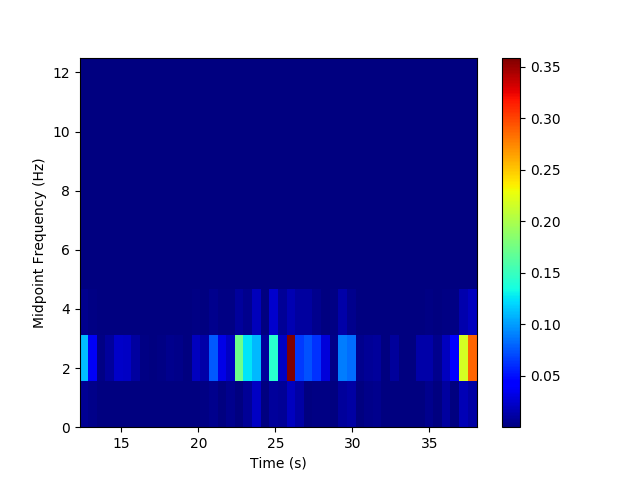

Could not find time equal to 14.56. Check framerate and retry.
Could not find time equal to 15.12. Check framerate and retry.


<IPython.core.display.Javascript object>


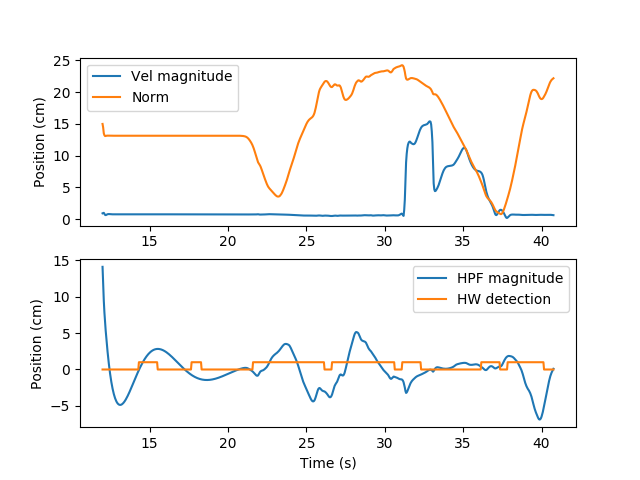

In [296]:
[hw_bool, HPF_mid, head_wag_idx, junk] = findHW(mid_norm,thresh = 0.01,fs=25)

# hw_bool = proc_pd['hw_bool'].astype(bool) #comment out for new data!

plt.figure()
plt.subplot(211)
plt.plot(T,mid_mag, label = 'Vel magnitude')
plt.plot(T,mid_norm, label='Norm')
# plt.plot(T,HPF_y,label = 'HPF')
plt.ylabel('Position (cm)')

plt.legend()
plt.subplot(212)
plt.plot(T,HPF_mid, label ='HPF magnitude')
plt.plot(T,hw_bool, label = "HW detection")
# plt.plot(T,np.abs(analytic_signal), label = "Envelope")
plt.ylabel('Position (cm)')
# plt.ylim((-5,5))
plt.legend()
plt.xlabel('Time (s)')


# Calculate HW Kinematics

In [254]:
analytic_signal = hilbert(HPF_y)
amplitude = np.mean(np.abs(analytic_signal[hw_bool]))
instantaneous_phase = np.unwrap(np.angle(analytic_signal))
hw_mfreq = np.mean(junk)#np.mean(np.diff(instantaneous_phase[hw_bool])/(2.0*np.pi) * fs)
hw_sfreq = np.std(junk)#np.std(np.diff(instantaneous_phase[hw_bool])/(2.0*np.pi) * fs)

# amplitude = np.mean(np.abs(mid_mag))
amp_s = np.std(np.abs(analytic_signal[hw_bool]))#np.std(np.abs(mid_mag))


# hw_spDens, 
hw_mfreq, amplitude, amp_s, 

(1.5625, 2.6234071656751916, 1.4114657185012287)

In [60]:
proc_pd

,frames,red_x,red_y,red x vel,red y vel,yellow_x,yellow_y,yellow x vel,yellow y vel,vector_dx,vector_dy,vector_mag,theta,view dist,cpd,nyst_bool,hw_bool
0,383.0,-2.627612,4.841364,-0.002279,-8.124184e-01,-3.330134,4.110616,-0.003865,-8.142053e-01,-0.702522,-0.730748,1.013671,-2.336504,29.839232,0.61527,0.0,0.0
1,384.0,-2.630722,7.049016,-0.002062,9.365479e-01,-3.335306,6.293555,-0.003530,9.491423e-01,-0.704584,-0.755462,1.033035,-2.321362,31.047257,0.64017,0.0,0.0
2,385.0,-2.633554,10.807266,-0.001356,1.090762e+00,-3.340048,10.043028,-0.002414,1.099042e+00,-0.706494,-0.764238,1.040765,-2.316953,32.791806,0.67612,0.0,0.0
3,386.0,-2.634455,12.135847,-0.000781,9.173657e-01,-3.341858,11.375861,-0.001450,9.220914e-01,-0.707402,-0.759986,1.038266,-2.320375,33.302790,0.68666,0.0,0.0
4,387.0,-2.634809,13.272671,-0.000423,5.963669e-01,-3.342738,12.513676,-0.000768,5.970358e-01,-0.707929,-0.758995,1.037900,-2.321397,33.692827,0.69469,0.0,0.0
5,388.0,-2.635039,13.675264,-0.000173,3.375148e-01,-3.343048,12.917541,-0.000325,3.360682e-01,-0.708009,-0.757723,1.037025,-2.322290,33.806857,0.69704,0.0,0.0
6,389.0,-2.635031,13.830441,-0.000016,1.706063e-01,-3.342945,13.071852,-0.000117,1.686685e-01,-0.707914,-0.758590,1.037594,-2.321653,33.859009,0.69812,0.0,0.0
7,390.0,-2.634905,13.885634,0.000065,6.616733e-02,-3.342906,13.126425,-0.000009,6.429747e-02,-0.708002,-0.759209,1.038106,-2.321307,33.912463,0.69922,0.0,0.0
8,391.0,-2.634707,13.843638,0.000071,2.001097e-02,-3.342770,13.083798,0.000016,1.871223e-02,-0.708063,-0.759840,1.038609,-2.320936,33.910720,0.69919,0.0,0.0
9,392.0,-2.634639,13.828878,0.000068,-2.996756e-03,-3.342723,13.068575,0.000014,-3.821660e-03,-0.708084,-0.760303,1.038962,-2.320647,33.909453,0.69916,0.0,0.0


In [10]:
plt.figure()
# plt.subplot(211)
# plt.plot(T,HPF_y,'.')
# plt.plot(T,HPF_x,'.')
# plt.subplot(212)
# plt.plot(midpt[0],midpt[1],'k.')
# plt.plot(midpt[0][0],midpt[1][0],'go')

# plt.plot(proc_pd['yellow_x'],proc_pd['yellow_y'],'k.')
plt.plot(proc_pd['yellow_x'][hw_on[1]:hw_off[1]],proc_pd['yellow_y'][hw_on[1]:hw_off[1]],'g.')
# plt.plot(proc_pd['red_x'],proc_pd['red_y'],'r.')
plt.show()
# (hw_off[1]-hw_on[1])/25

<IPython.core.display.Javascript object>

NameError: name 'hw_on' is not defined

# cpd and viewing distance

In [148]:
print Date,ID,rot_speed
# rot_speed=6.
exp_log[(exp_log['ID']==ID)& (exp_log['Speed']==rot_speed)]#['Grating'].values[0]
# ID = 31
# Date = 0
# Date = 160722
# len(spDens),len(mid_norm)
# len(theta), len(vector_mag), len(vectors)

170201 90 30


,ID,Date,Speed,1st rot,Grating,Lights,Temp,RH,TOD,DA,LID,Marker dist,Mass,Light resp,Nyst resp


In [255]:
exp_log = pd.read_csv('/Users/sazamore/Documents/Visuomotor/experiment_log.csv')

grating = eval(exp_log[(exp_log['Date']==int(Date)) & (exp_log['ID']==ID) & (exp_log['Speed']==rot_speed/6)]['Grating'].values[0])
vector_mag = np.sqrt(vectors[:,0]**2 + vectors[:,1]**2)

    
print('Grating size is {}.'.format(grating))
grating = [grating *2.54]    #convert grating distance to cm
global grating
per = 2*grating    #calculate period
diam = 44.45  #diameter in cm

x,y = cpd.make_circ(diam/2)
circle = cpd.Polygon(zip(x,y))
dt = np.linspace(0.01,44.45,800)

#cpd,view_dist = cpd.calc_view_dist(yellow_mat[:,:2],vector_mag)
spDens,view_dist = cpd.calc_view_dist(np.column_stack([proc_pd['yellow_x'].values,proc_pd['yellow_y'].values]),vector_mag,circle,theta,grating,dt)
spDens = np.array(spDens)
# print '\a'

Grating size is 0.05.


In [256]:
spDens[0],proc_pd['cpd'][0]

(3.4136299999999999, 1.70686)

In [257]:
#save updated cpd/grating data
proc_pd['cpd']=spDens
proc_pd = proc_pd.to_pickle #(open(filename, "rb" ) )


In [403]:
#for proc data only
spDens = proc_pd['cpd'].values
view_dist = proc_pd['view dist'].values


In [258]:
#get onset and offsets of head wags, number of hw events, and duration
hw_on = np.where(np.diff(hw_bool.astype(int))==1)[0]+1
hw_off = np.where(np.diff(hw_bool.astype(int))==-1)[0]

hw_view = []
hw_amp = []
hw_freq = []
cpd_val = []
select = []
reject = []

for i in range(len(hw_on)):
#     analytic_signal = hilbert(mid_KF[0].T[1][hw_on[i]:hw_off[i]])
    analytic_signal = hilbert(HPF_y[hw_on[i]:hw_off[i]])
    
    #hilbert doc instantaneous frequency removed becuase it keeps giving negative freq

#     yf = scipy.fftpack.fft(mid_KF[0].T[1][hw_on[i]:hw_off[i]])
#     yf = scipy.fftpack.fft(midpt[1][hw_on[i]:hw_off[i]])

#     N = hw_off[i]-hw_on[i]
#     xf = np.linspace(0.0, 1.0/(2.0/fs), N/2)
#     power = 2.0/N * np.abs(yf[:N//2])
    amplitude = np.mean(np.abs(analytic_signal))
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    freq =np.diff(instantaneous_phase)/(2.0*np.pi) * fs
    hw_mfreq = np.mean(freq[np.where(freq>0.1)[0]])
    hw_sfreq = np.std(freq[np.where(freq>0.1)[0]])#np.std(xf*power)
#     hw_mfreq = np.mean(xf*power)
#     hw_sfreq = np.std(xf*power)

    if hw_mfreq>=0.1 and hw_sfreq<hw_mfreq:
        #viewing distance is the position at the onset of the head wag
        hw_view.append([np.mean(view_dist[hw_on[i]:hw_off[i]]),np.std(view_dist[hw_on[i]:hw_off[i]])])
        cpd_val.append([np.mean(spDens[hw_on[i]:hw_off[i]]),np.std(spDens[hw_on[i]:hw_off[i]])])
        hw_amp.append(np.array([np.mean(np.abs(analytic_signal)),np.std(np.abs(analytic_signal))]))
    #     idx1 = int(np.where(head_wag_idx==hw_on[i])[0])
#     try:
#         idx2 = int(np.where(head_wag_idx==hw_on[i+1])[0]-1)
#     except:
#         idx2 = len(junk)-1
#         print idx1,idx2
#         pdb.set_trace()
        hw_freq.append([hw_mfreq,hw_sfreq])#[np.mean(junk[idx1:idx2]),np.std(junk[idx1:idx2])])
        select.append(i)
        reject.append(i)

num_events = len(hw_on[select])#skip the first detection event, it's usually noise.
duration = (hw_off[select]-hw_on[select])/fs #duration of events, in seconds

In [259]:
# analytic_signal = hilbert(midpt[1])#[hw_on[i]:hw_off[i]])
hw_freq,hw_amp,hw_view, duration, len(reject)
# len(all_freq)

([[0.52157449517150467, 0.35591224361599377],
  [0.3058784048148695, 0.25452806116371063],
  [1.0801401814345177, 0.70776431440587928],
  [0.3512975731692865, 0.2050912539997311],
  [0.45254433304286806, 0.38056189923305384],
  [2.905570395704979, 1.5186924645850872],
  [1.0785784832254282, 0.65655500508163767],
  [0.46630584298206057, 0.26850130460221738]],
 [array([ 3.57787014,  1.41804588]),
  array([ 3.19282457,  0.3698024 ]),
  array([ 1.51513036,  0.82478615]),
  array([ 2.09431473,  0.8247404 ]),
  array([ 1.42414834,  0.34091709]),
  array([ 0.08914927,  0.06333648]),
  array([ 1.05814029,  0.55835995]),
  array([ 1.61638324,  0.7411589 ])],
 [[40.959140598328474, 0.56693640890771202],
  [40.751012465805701, 0.34478473053184339],
  [38.503393615666525, 1.4473665696394749],
  [33.864025280231324, 1.2363266609829437],
  [38.055284347447902, 0.50056148347401141],
  [36.083959204139404, 1.0529949810339996],
  [35.886139088820748, 1.905167375477637],
  [47.144238354125719, 4.2705916

In [16]:
# okr_hw = {'ID':[],'file':[],'hw_view':[],'cpd':[],'num_events':[],'duration':[],'hw_on':[],'hw_off':[],'head_freq':[],'head_amp':[]}

In [260]:
#update okr_hw
okr_hw['ID'].extend(list(np.ones(num_events)*ID))
okr_hw['file'].extend([filename])
okr_hw['hw_view'].extend([hw_view])
okr_hw['cpd'].extend([cpd_val])
okr_hw['num_events'].extend([num_events])
okr_hw['duration'].extend([duration])
okr_hw['hw_on'].extend(hw_on)
okr_hw['hw_off'].extend(hw_off)
okr_hw['head_freq'].append(hw_freq)
okr_hw['head_amp'].append(hw_amp)

In [82]:
len(okr_hw['cpd']),len(okr_hw['head_freq']), np.transpose(okr_hw['hw_view'])[0],len(okr_hw['duration'])

(1, 1, array([[ 34.24587853],
        [ 29.29809988],
        [ 24.32880612],
        [ 10.77929875],
        [ 24.03410243],
        [ 12.10023781]]), 1)

In [314]:
# for key in okr_hw.keys():
#     okr_hw[key]=okr_hw[key][:-1]
np.unique(okr_hw['file'])

array(['31_01rpm160722_-processed.p', '81_02rpm-2-170722_processed.p',
       '81_02rpm_170722_processed.p', '90_01rpm_160801_processed.p',
       '94_.5rpm_170208-2_processed.p'], 
      dtype='|S29')

# plot ensemble data

In [261]:
all_dist = []
all_freq = []
all_amp = []
all_dur = []
freq_dist = []
all_cpd = []

# all_dist_lg = []
# all_freq_lg = []
# all_amp_lg = []
# all_dur_lg = []
# all_dist_sm = []
# all_freq_sm = []
# all_amp_lg = []
# all_dur_lg = []
for i in range(len(okr_hw['cpd'])):

    all_dist.extend(np.transpose(okr_hw['hw_view'][i])[0])
    all_cpd.extend(np.transpose(okr_hw['cpd'][i])[0])

#         select = np.where(np.transpose(okr_hw['head_freq'][i])[0]>=0.2)[0]
#         freq_dist.extend(np.transpose(okr_hw['hw_view'][i])[0][select])
    all_freq.extend(np.transpose(okr_hw['head_freq'][i])[0])
    all_amp.extend(np.transpose(okr_hw['head_amp'][i])[0])
    all_dur.extend(okr_hw['duration'][i])

In [262]:
    
slope, intercept, r_value, p_value, std_err = stats.linregress(all_cpd,all_freq)
freqcpd = slope*np.array(all_cpd)+intercept
# plt.plot(bin_centers[drop_idx],line,':')
p_value,r_value**2


(0.14553963165043193, 0.074119963027497363)

pvalue, r^2
N=3, n=12
durline - (0.97782885885243753, 2.8080008663519923e-05)
ampline - (0.10768858666722982, 0.089784180921913398)
freqline - (0.243340734378035, 0.048279582774708514)

durcpd = (0.0025632228993140451, 0.28143861846734908)
ampcpd = (0.065101524925216037, 0.11633756809476026)
freqcpd = (0.010707129140200245, 0.21079012981336268)


In [330]:
bin_means_s, bin_edges, binnumber= scipy.stats.binned_statistic(all_dist_sm,all_freq_sm,'mean',bins=1)
bin_std_s, bin_edges, binnumber= scipy.stats.binned_statistic(all_dist_sm,all_freq_sm,np.std,bins=1)

scipy.stats.ttest_ind(all_freq_sm,all_freq_lg)

NameError: name 'all_dist_sm' is not defined

In [267]:
rot_spd = []
for i in range(len(okr_hw['file'])):
    spd = float(okr_hw['file'][i][3:5])
    rot_spd.append(int(spd*2))

In [282]:
# rot_spd = rot_spd[:]*2
rot_spd, len(okr_hw['cpd']),np.transpose(okr_hw['head_freq'][i])[1]

([2, 2, 10, 1, 4, 8],
 6,
 array([ 0.52507761,  0.09566167,  0.62990179,  0.16611341,  0.10937055,
         0.75597751]))

<IPython.core.display.Javascript object>


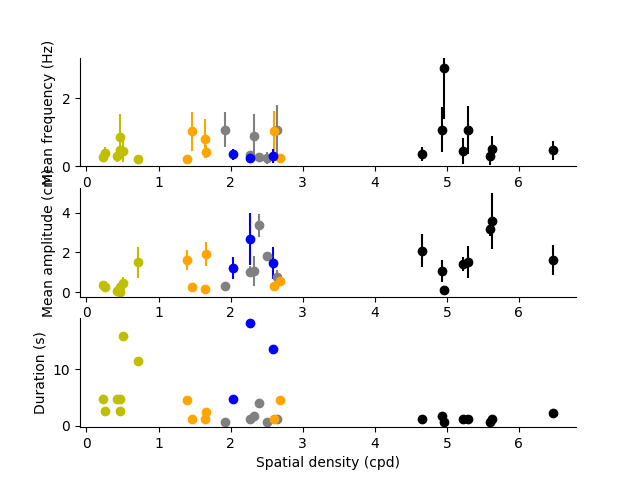

In [284]:
cval = ['r','orange','y','g','b','purple','m','k','k','gray','gray']
# cval = ['k','k','k','k','k','k','k','k','k']
plt.figure()
for i in range(len(okr_hw['cpd'])):
    ax = plt.subplot(311)
#     plt.title('Kinematics by viewing distance')
    plt.errorbar(np.transpose(okr_hw['cpd'][i])[0],np.transpose(okr_hw['head_freq'][i])[0],yerr=np.transpose(okr_hw['head_freq'][i])[1],fmt='o',mec=cval[rot_spd[i]],mfc=cval[rot_spd[i]],ecolor=cval[rot_spd[i]])
#     plt.plot(all_cpd,freqcpd,'m:')

#     ticks = plt.gca()    
#     ticks.axes.xaxis.set_ticklabels([])
    plt.ylim((0,3.2))
    plt.ylabel('Mean frequency (Hz)')
    plt.xlabel('Spatial density (cpd)')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

# plt.figure()
# for i in range(len(okr_hw['cpd'])):
    ax = plt.subplot(312)
    plt.errorbar(np.transpose(okr_hw['cpd'][i])[0],np.transpose(okr_hw['head_amp'][i])[0],yerr=np.transpose(okr_hw['head_amp'][i])[1],fmt='o',mec=cval[rot_spd[i]],mfc=cval[rot_spd[i]],ecolor=cval[rot_spd[i]])
    plt.ylabel('Mean amplitude (cm)')
#     ticks = plt.gca()
#     ticks.axes.xaxis.set_ticklabels([])
    plt.xlabel('Spatial density (cpd)')
#     plt.xlabel('Viewing distance (cm)')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

# plt.figure()
# for i in range(len(okr_hw['cpd'])):
    ax = plt.subplot(313)
    plt.plot(np.transpose(okr_hw['cpd'][i])[0],okr_hw['duration'][i],'o',mec=cval[rot_spd[i]],mfc=cval[rot_spd[i]])
    plt.ylabel('Duration (s)')
#     plt.plot(all_cpd,durcpd,'m:')
    plt.xlabel('Spatial density (cpd)')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

<IPython.core.display.Javascript object>


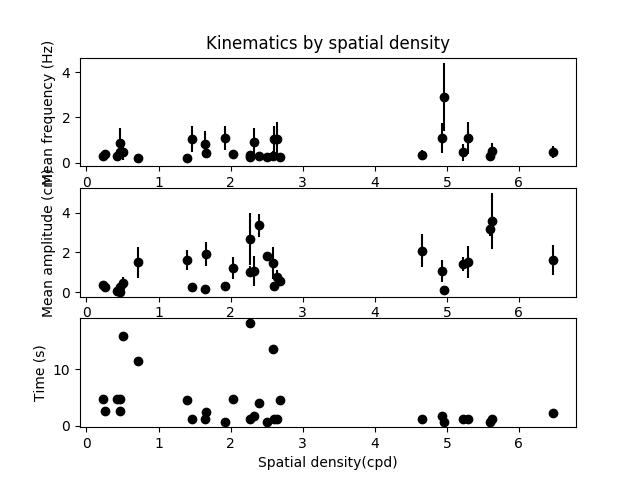

In [297]:
cval = 'k'
plt.figure()
for i in range(len(okr_hw['cpd'])):
    if i > 3:
        cval = 'k'
    plt.subplot(311)
    plt.title('Kinematics by spatial density')
    plt.errorbar(np.transpose(okr_hw['cpd'][i])[0],np.transpose(okr_hw['head_freq'][i])[0],yerr=np.transpose(okr_hw['head_freq'][i])[1],fmt='o',ecolor=cval,mec=cval,mfc=cval)
    plt.ylabel('Mean frequency (Hz)')
#     plt.ylim((0,0.3))
    plt.subplot(312)
    plt.errorbar(np.transpose(okr_hw['cpd'][i])[0],np.transpose(okr_hw['head_amp'][i])[0],yerr=np.transpose(okr_hw['head_amp'][i])[1],fmt='o',ecolor=cval,mec=cval,mfc=cval)
    plt.ylabel('Mean amplitude (cm)')
    # plt.subplot(413)
    # plt.plot(np.transpose(okr_hw['hw_view'])[0][1:], okr_hw['num_events'],'o')
    # plt.ylabel('Count')
    plt.subplot(313)
    plt.plot(np.transpose(okr_hw['cpd'][i])[0],okr_hw['duration'][i],'o',mec=cval,mfc=cval)
    plt.ylabel('Time (s)')
    plt.xlabel('Spatial density(cpd)')

In [1093]:
#save okr_hw
with open('okr_hw_data.csv', 'wb') as csv_file:
    writer = csv.writer(csv_file)
    for key, value in okr_hw.items():
        writer.writerow([key, value])

<IPython.core.display.Javascript object>


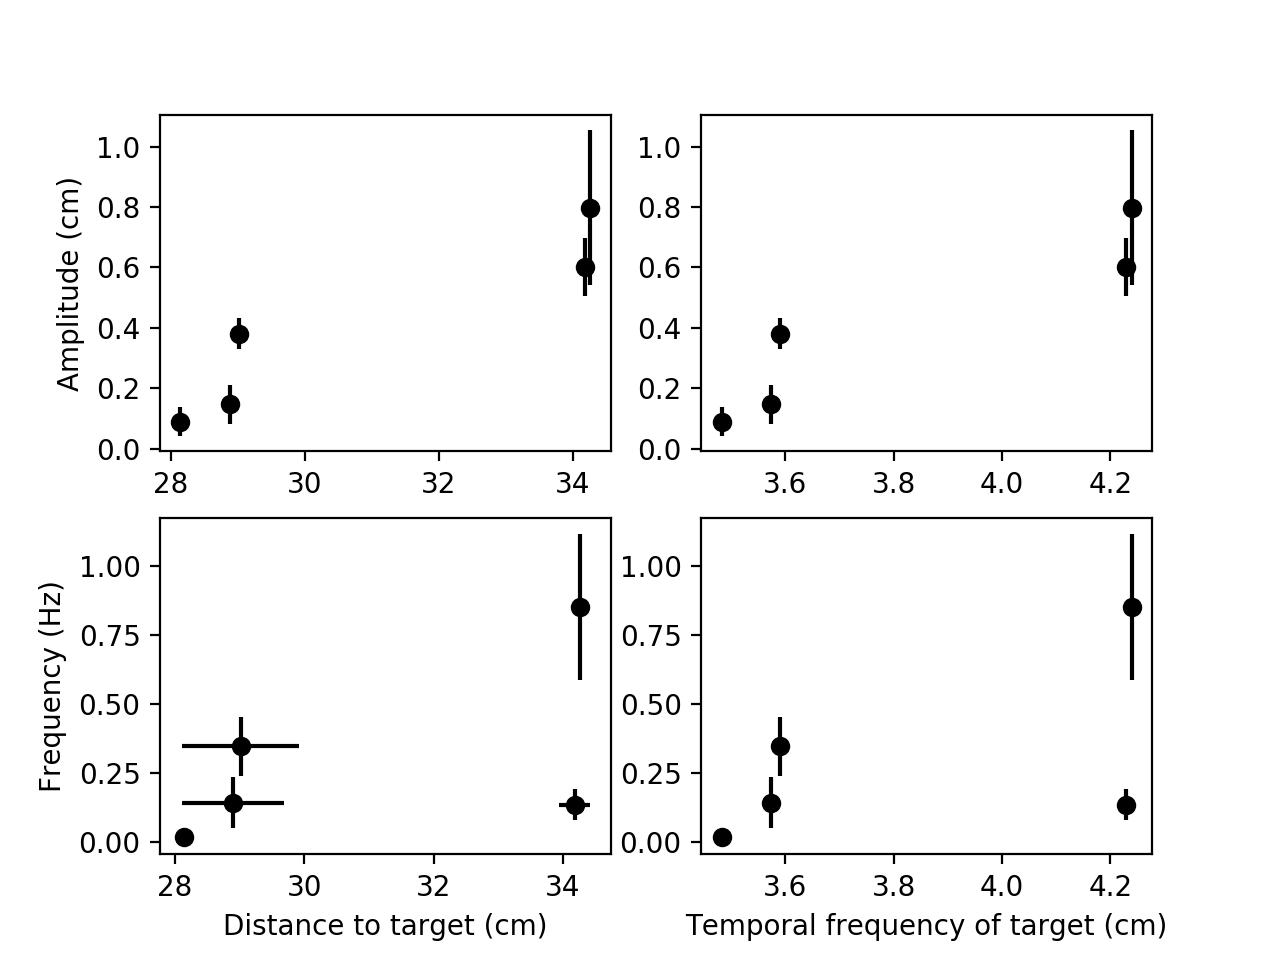

In [110]:
plt.figure()

for i in range(len(view_distance)):
    plt.subplot(221)
    plt.errorbar(np.mean(view_distance[i]), hw_amp[i][0],yerr=hw_amp[i][1],fmt='ko')
    plt.ylabel('Amplitude (cm)')
    plt.subplot(222)
    plt.errorbar(np.mean(cpd_val[i]*rot_speed), hw_amp[i][0],yerr=hw_amp[i][1],fmt='ko')
#     plt.xlabel('Distance to target (cm)')
    plt.subplot(223)
    plt.errorbar(np.mean(view_distance[i]), hw_freq[i][0],yerr=hw_freq[i][1],xerr=np.std(view_distance[i]),fmt='ko')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Distance to target (cm)')
    plt.subplot(224)
    plt.errorbar(np.mean(cpd_val[i])*rot_speed, hw_freq[i][0],yerr=hw_freq[i][1],fmt='ko')
    plt.xlabel('Temporal frequency of target (cm)')

In [1136]:
OKR_dict = {'freq':all_freq,'amp':all_amp,'dur':all_dur,'dist':all_dist}
OKR_HW = pd.DataFrame(OKR_dict)
OKR_HW.to_csv('OKR_HW_kin.csv')

In [1137]:
OKR_HW

,amp,dist,dur,freq
0,3.442232,34.264346,0.60,0.349546
1,1.295822,34.221844,0.60,1.886335
2,0.619014,29.014801,1.16,0.521680
3,1.751023,34.245879,4.76,0.309432
4,0.449596,29.298100,4.76,0.219181
5,0.616887,24.328806,7.00,0.564442
6,0.678266,10.779299,4.76,0.226695
7,0.432986,24.034102,2.52,0.998569
8,0.197887,12.100238,2.52,0.377490
9,0.248302,29.508218,23.00,0.211930


In [693]:
#Save processed data thus far, append hw data to storage dict
processed_data = np.column_stack((frames,raw_mat[:,:8],vectors[0],vectors[1],\
                                  vector_mag,theta,view_dist,spDens,hw_bool))

processed_pd = pd.DataFrame(processed_data,
                      columns = ['frames','red_x','red_y','red x vel','red y vel','yellow_x',\
                                 'yellow_y','yellow x vel','yellow y vel','vector_dx','vector_dy',\
                                 'vector_mag','theta','view dist','cpd','hw_bool'])
savename = filename[:len(filename)-5]+'HW.p'
print('Savename will be {}'.format(savename))
#nameOK = input('Continue with savename? (Y/n) ')

#if np.strmatch('n'):
#    savename = input('Enter savename, complete with extentsion: ')

processed_pd.to_pickle(savename)
print('Data saved to {}'.format(savename))

# store = {'ID':[],'file':[],'rot_speed':[],'view_dist':[], 'spatial_freq':[],'head_amp':[],'head_freq':[],'duration':[]}
store['ID'].append([ID])
store['file'].append([files[m]])
store['rot_speed'].append([rot_speed])
store['view_dist'].append([view_distance])
store['spatial_freq'].append([cpd_val])
store['head_amp'].append([hw_amp])
store['head_freq'].append([hw_freq])
store['duration'].append([duration])


Savename will be 81_02rpm-2-170722_HW.p
Data saved to 81_02rpm-2-170722_HW.p


In [592]:
len(grating)

7

<IPython.core.display.Javascript object>


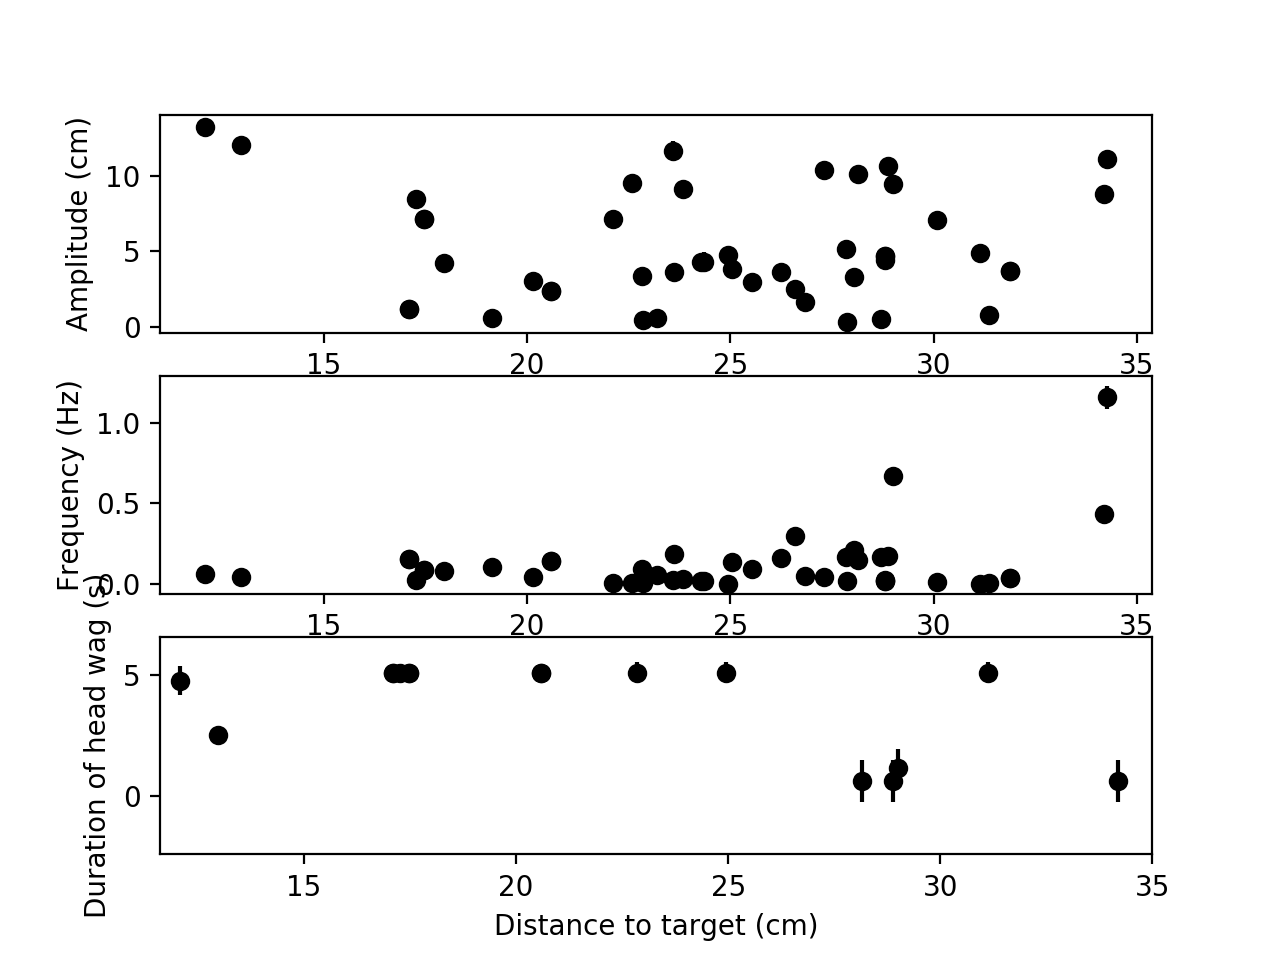

In [705]:
#Plot summed data:
colors = ['r','b','orange','k','m','g','y','purple']
plt.figure()
for j in range(len(store['ID'])):
    for i in range(len(store['view_dist'][j])):
        plt.subplot(311)
        distances = []
        for n in range(len(store['view_dist'][j][i])):
            distances.append(np.mean(store['view_dist'][j][i][n]))
        x = np.array(distances)
        y = np.transpose(store['head_amp'][j][i])[0]
        yerr = np.transpose(store['head_amp'][j][i])[1]/len(distances)

        plt.errorbar(x,np.abs(y),yerr=np.abs(yerr),fmt='ko')#,mfc=colors[j],mec=colors[j])
        plt.ylabel('Amplitude (cm)')
#         plt.xlim([0,40])

        plt.subplot(312)
        y = np.transpose(store['head_freq'][j][i])[0]
        yerr = np.transpose(store['head_freq'][j][i])[1]/len(distances)
        plt.errorbar(x,y,yerr=yerr,fmt='ko')
        plt.ylabel('Frequency (Hz)')
        
        plt.subplot(313)
        y = np.transpose(store['duration'][j][i])
        yerr = np.transpose(store['duration'][j][i])/len(distances)-1
        plt.errorbar(x[1:],y,yerr=yerr,fmt='ko')
        plt.ylabel('Duration of head wag (s)')
        plt.xlabel('Distance to target (cm)')

In [602]:
all_view = []
all_amp = []
all_freq = []
all_dur = []
view_dur = []
for j in range(len(store['ID'])):
    mview = []
    for i in range(len(store['view_dist'][j][0])):
        mview.append(np.mean(store['view_dist'][j][0][i]))
    all_view.extend([mview])
    all_amp.extend(np.transpose(store['head_amp'][j])[0])
    all_freq.extend(np.transpose(store['head_freq'][j])[0])
    all_dur.extend(np.transpose(store['duration'][j][0]))
    view_dur.extend(store['view_dist'][j][0][1:])

def fixformat(data):
    av = []
    for i in range(len(data)):
#         pdb.set_trace()
#         for j in range(len(data[i])):
        av.extend(data[i])
    return av

# all_view = fixformat(all_view)
all_amp = list(np.array(np.abs(all_amp)).ravel())#FIX!
all_freq = list(np.array(all_freq).ravel())

# all_dur = fixformat(all_dur)
# all_freq = fixformat(all_freq)
# view_dur = fixformat(view_dur)


In [609]:
# mview=[]
for i in range(len(store['view_dist'][2][0])):
    mview.append(np.mean(store['view_dist'][0][0][i]))
# #     pdb.set_trace
# mview.append(np.mean(store['view_dist'][6][0][0]))
# vd = []
# for i in range(len(view_dur)):
#     vd.append(np.mean(view_dur[i]))
# vd

mview

IndexError: list index out of range

In [603]:
bin_count, bin_edges, binnumber= scipy.stats.binned_statistic(mview,all_freq[:-1],'count',bins=25)
bin_means, bin_edges, binnumber= scipy.stats.binned_statistic(all_view,all_freq[:-1],'mean',bins=25)
bin_std, bin_edges, binnumber= scipy.stats.binned_statistic(all_view,all_freq[:-1],np.std,bins=25)

#Duration data
# bin_count, bin_edges, binnumber= scipy.stats.binned_statistic(vd,all_dur,'count',bins=15)
# bin_means, bin_edges, binnumber= scipy.stats.binned_statistic(vd,all_dur,'mean',bins=15)
# bin_std, bin_edges, binnumber= scipy.stats.binned_statistic(vd,all_dur,np.std,bins=15)

bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

ValueError: setting an array element with a sequence.

In [598]:
plt.figure()
plt.errorbar(bin_centers[drop_idx], bin_means[drop_idx],yerr=bin_std[drop_idx]/bin_count[drop_idx],fmt='o')# colors='g', lw=2, label='binned statistic of data')
plt.title('Mean head wag frequency by distance')
plt.xlabel('Distance to target (cm)')
plt.ylabel('Frequency (cm)')
slope, intercept, r_value, p_value, std_err = stats.linregress(bin_centers[drop_idx],bin_means[drop_idx])
line = slope*bin_centers[drop_idx]+intercept
plt.plot(bin_centers[drop_idx],line,':')
print p_value, r_value

AttributeError: The number of `values` elements must match the length of each `sample` dimension.

In [576]:
np.max(all_freq)

1.1573398080028123

In [599]:
bin_means
# drop_idx = [0,3,4,5,6,7,8,9,10,11,12,14] #duration data
drop_idx = [0,1,2,4,7,8,9,10,11,13,14,15,16,17,18,20,24]
# bin_means,bin_means[drop_idx]


IndexError: index 15 is out of bounds for axis 1 with size 15